In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print("TF Version: " + tf.__version__)

TF Version: 2.16.1


### Data Preperation
Here we are selecting a small percentage of the original dataset, this is to increase the speed at which the models train.
This is done using the line dataset = dataset.sample

We then drop the region column from the dataset as we will not be using it in the training of the models
e:

In [16]:
#Read data from file

raw_dataset = pd.read_csv("insurance_dataset.csv", sep=',',decimal='.')


In [17]:
dataset = raw_dataset.copy()
dataset = dataset.sample(frac=0.005, random_state=42)#0.5% of 1 million = 5,000, likely need to increase
dataset.drop(columns=['region'], inplace=True) #Drop the region as we will not be using it
print("Number of rows in the dataset after sampling:", dataset.shape[0])
dataset.reset_index(drop=True, inplace=True)
dataset.tail(9)

Number of rows in the dataset after sampling: 5000


,age,gender,bmi,children,smoker,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
4991,42,male,31.18,3,yes,High blood pressure,Diabetes,Never,Blue collar,Basic,16272.151930
4992,46,male,28.89,4,yes,Diabetes,Heart disease,Frequently,Unemployed,Standard,22953.606080
4993,57,male,35.78,5,yes,Diabetes,Diabetes,Frequently,White collar,Standard,21828.655940
4994,21,male,22.20,2,no,NaN,Diabetes,Rarely,Student,Basic,7782.781926
4995,46,female,43.61,3,yes,High blood pressure,Heart disease,Rarely,Student,Standard,19765.111890
4996,28,female,34.46,3,no,NaN,Diabetes,Frequently,Unemployed,Basic,9406.823145
4997,65,male,33.47,0,no,Heart disease,High blood pressure,Occasionally,Blue collar,Basic,15161.968770
4998,56,male,39.00,3,no,NaN,Heart disease,Frequently,Student,Standard,16416.199640
4999,65,male,18.34,1,yes,NaN,High blood pressure,Frequently,White collar,Premium,20258.384190


In [18]:
from sklearn.preprocessing import LabelEncoder
# Create label encoder
label_encoder = LabelEncoder()
# Define ordinal mappings for ordinal variables
ordinal_mappings = {
    "gender": {"male": 0, "female": 1},
    "smoker": {"no": 0, "yes": 1},
    "medical_history": {np.NAN: 0, "Heart disease": 1, "High blood pressure": 2, "Diabetes": 3},
    "family_medical_history": {np.NAN: 0, "Heart disease": 1, "High blood pressure": 2, "Diabetes": 3},
    "exercise_frequency": {"Never": 0, "Rarely": 1, "Occasionally": 2, "Frequently": 3},
    "occupation": {"Unemployed": 0, "Student": 1, "Blue collar": 2, "White collar": 3},
    "coverage_level": {"Basic": 0, "Standard": 1, "Premium": 2}
}
def encode_values(new_dataset):
    # Apply ordinal encoding to ordinal variables
    new_dataset.replace(ordinal_mappings, inplace=True)
    return new_dataset

# Apply the function to your dataset
dataset = encode_values(dataset)


dataset.tail(9)

,age,gender,bmi,children,smoker,medical_history,family_medical_history,exercise_frequency,occupation,coverage_level,charges
4991,42,0,31.18,3,1,2,3,0,2,0,16272.151930
4992,46,0,28.89,4,1,3,1,3,0,1,22953.606080
4993,57,0,35.78,5,1,3,3,3,3,1,21828.655940
4994,21,0,22.20,2,0,0,3,1,1,0,7782.781926
4995,46,1,43.61,3,1,2,1,1,1,1,19765.111890
4996,28,1,34.46,3,0,0,3,3,0,0,9406.823145
4997,65,0,33.47,0,0,1,2,2,2,0,15161.968770
4998,56,0,39.00,3,0,0,1,3,1,1,16416.199640
4999,65,0,18.34,1,1,0,2,3,3,2,20258.384190


In [19]:
'''from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Assuming 'coverage_level' is a column in your dataset
# Convert 'coverage_level' to categorical data type (optional but recommended)
dataset['coverage_level'] = dataset['coverage_level'].astype('category')

# Drop the 'coverage_level' column temporarily
coverage_level = dataset.pop('coverage_level')

# Initialize SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='most_frequent')
dataset_imputed = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the coverage_level column
coverage_encoded = encoder.fit_transform(coverage_level.values.reshape(-1, 1))

# Convert the encoded sparse matrix to a dense array and create a DataFrame
coverage_encoded_df = pd.DataFrame(coverage_encoded.toarray(), columns=encoder.get_feature_names_out(['coverage_level']))

# Concatenate the imputed dataset with the one-hot encoded coverage level
dataset_encoded = pd.concat([dataset_imputed, coverage_encoded_df], axis=1)

dataset = dataset_encoded

# Print the head of the encoded dataset
dataset.tail()'''

"from sklearn.preprocessing import OneHotEncoder\nfrom sklearn.impute import SimpleImputer\n\n# Assuming 'coverage_level' is a column in your dataset\n# Convert 'coverage_level' to categorical data type (optional but recommended)\ndataset['coverage_level'] = dataset['coverage_level'].astype('category')\n\n# Drop the 'coverage_level' column temporarily\ncoverage_level = dataset.pop('coverage_level')\n\n# Initialize SimpleImputer to handle missing values\nimputer = SimpleImputer(strategy='most_frequent')\ndataset_imputed = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)\n\n# Initialize OneHotEncoder\nencoder = OneHotEncoder()\n\n# Fit and transform the coverage_level column\ncoverage_encoded = encoder.fit_transform(coverage_level.values.reshape(-1, 1))\n\n# Convert the encoded sparse matrix to a dense array and create a DataFrame\ncoverage_encoded_df = pd.DataFrame(coverage_encoded.toarray(), columns=encoder.get_feature_names_out(['coverage_level']))\n\n# Concatenat

In [20]:
from sklearn.model_selection import train_test_split, GridSearchCV


# Split the encoded dataset into features (X) and target variables (y_charges, y_coverage)
X = dataset.drop(columns=['charges', 'coverage_level'])  # Features
y_charges = dataset['charges']  # Target variable for charges
y_coverage = dataset['coverage_level']  # Target variable for coverage

# Split the data into training and testing sets for charges and coverage separately
X_train, X_test, y_charges_train, y_charges_test = train_test_split(
    X, y_charges, test_size=0.2, random_state=42
)
X_train, X_test, y_coverage_train, y_coverage_test = train_test_split(
    X, y_coverage, test_size=0.2, random_state=42
)

# Concatenate the target variables
y_train = pd.concat([y_charges_train, y_coverage_train], axis=1)
y_test = pd.concat([y_charges_test, y_coverage_test], axis=1)

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (4000, 9)
Shape of y_train: (4000, 2)
Shape of X_test: (1000, 9)
Shape of y_test: (1000, 2)


In [21]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler on training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor


### Multi Output Random Forest Regressor

This random forest regressor is wrapped with a multi output regressor to make it so that we can predict both 

In [28]:
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'estimator__max_depth': [10, 20, 30],
    'estimator__n_estimators': [100, 200, 300]
}


# Instantiate Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Wrap the Random Forest regressor with MultiOutputRegressor
multioutput_regressor = MultiOutputRegressor(rf_regressor)

# Perform grid search with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=multioutput_regressor, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search_rf.best_estimator_

# Make predictions on the testing data
y_pred_rf = best_rf_model.predict(X_test)

# Split the predictions into separate arrays for charges and coverage
y_charges_pred_rf = y_pred_rf[:, 0]  # Assuming charges is the first output variable
y_coverage_pred_rf = y_pred_rf[:, 1]  # Assuming coverage is the second output variable

# Calculate Mean Squared Error (MSE)
mse_charges_rf = mean_squared_error(y_charges_test, y_charges_pred_rf)
mse_coverage_rf = mean_squared_error(y_coverage_test, y_coverage_pred_rf)
print("Mean Squared Error (Charges):", mse_charges_rf)
print("Mean Squared Error (Coverage Level):", mse_coverage_rf)

# Calculate Mean Absolute Error (MAE)
mae_charges_rf = mean_absolute_error(y_charges_test, y_charges_pred_rf)
mae_coverage_rf = mean_absolute_error(y_coverage_test, y_coverage_pred_rf)
print("Mean Absolute Error (Charges):", mae_charges_rf)
print("Mean Absolute Error (Coverage Level):", mae_coverage_rf)

# Calculate R-squared
r2_charges_rf = r2_score(y_charges_test, y_charges_pred_rf)
r2_coverage_rf = r2_score(y_coverage_test, y_coverage_pred_rf)
print("R-squared (Charges):", r2_charges_rf)
print("R-squared (Coverage Level):", r2_coverage_rf)

Mean Squared Error (Charges): 4979655.2293741135
Mean Squared Error (Coverage Level): 0.6485561332617651
Mean Absolute Error (Charges): 1896.5094134439175
Mean Absolute Error (Coverage Level): 0.6666851445441988
R-squared (Charges): 0.7462889005090408
R-squared (Coverage Level): -0.005864267786072741


### Multi output SVM Regressor

Here we use the SVR Model from sklearn to create a SVM regression model that will predict the charges and the coverage type


In [29]:
from sklearn.svm import SVR

# 1. Instantiate the SVM Regressor
svm_regressor = SVR()

# 2. Hyperparameter Tuning
param_grid = {
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__C': [0.1, 1, 10],
    'estimator__epsilon': [0.1, 0.2, 0.5]
}
##Wrap the svm regressor in a multi output regressor
grid_search_svm = GridSearchCV(estimator=MultiOutputRegressor(svm_regressor), param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# 3. Train the Model
grid_search_svm.fit(X_train, y_train)

# 4. Evaluate the Model
best_svm_model = grid_search_svm.best_estimator_
y_pred_nn = best_svm_model.predict(X_test)
y_charges_pred_svm = y_pred_nn[:, 0]  #Charges is the first output variable
y_coverage_pred_svm = y_pred_nn[:, 1]  #Coverage is the second output variable


# Calculate Mean Squared Error (MSE)
mse_charges_svm = mean_squared_error(y_charges_test, y_charges_pred_svm)
mse_coverage_svm = mean_squared_error(y_coverage_test, y_coverage_pred_svm)
print("Mean Squared Error (Charges):", mse_charges_svm)
print("Mean Squared Error (Coverage Level):", mse_coverage_svm)

# Calculate Mean Absolute Error (MAE)
mae_charges_svm = mean_absolute_error(y_charges_test, y_charges_pred_svm)
mae_coverage_svm = mean_absolute_error(y_coverage_test, y_coverage_pred_svm)
print("Mean Absolute Error (Charges):", mae_charges_svm)
print("Mean Absolute Error (Coverage Level):", mae_coverage_svm)

# Calculate R-squared
r2_charges_svm = r2_score(y_charges_test, y_charges_pred_svm)
r2_coverage_svm = r2_score(y_coverage_test, y_coverage_pred_svm)
print("R-squared (Charges):", r2_charges_svm)
print("R-squared (Coverage Level):", r2_coverage_svm)



Mean Squared Error (Charges): 12365562.795422452
Mean Squared Error (Coverage Level): 0.8776940997308418
Mean Absolute Error (Charges): 2823.2837946796585
Mean Absolute Error (Coverage Level): 0.8138976265065494
R-squared (Charges): 0.3699803725075461
R-squared (Coverage Level): -0.3612408975702248


### Multi-output Neural Network 

Here we use the NN Model from tensorflow to create a NN regression model that will predict the charges and the coverage type

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Define the neural network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(9,)),
    Dense(32, activation='relu'),
    Dense(2)  # Two outputs for charges and coverage
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nn_model.fit(X_train, y_train, epochs=40, batch_size=8, validation_split=0.2)

# Make predictions on the test data
y_pred_nn = nn_model.predict(X_test)
# Split the predictions into charges and coverage level
y_charges_pred_nn = y_pred_nn[:, 0]  # Charges is the first output variable
y_coverage_pred_nn = y_pred_nn[:, 1]  # Coverage is the second output variable

# Calculate Mean Squared Error (MSE)
mse_charges_nn = mean_squared_error(y_charges_test, y_charges_pred_nn)
mse_coverage_nn = mean_squared_error(y_coverage_test, y_coverage_pred_nn)
print("Mean Squared Error (Charges):", mse_charges_nn)
print("Mean Squared Error (Coverage Level):", mse_coverage_nn)

# Calculate Mean Absolute Error (MAE)
mae_charges_nn = mean_absolute_error(y_charges_test, y_charges_pred_nn)
mae_coverage_nn = mean_absolute_error(y_coverage_test, y_coverage_pred_nn)
print("Mean Absolute Error (Charges):", mae_charges_nn)
print("Mean Absolute Error (Coverage Level):", mae_coverage_nn)

# Calculate R-squared
r2_charges_nn = r2_score(y_charges_test, y_charges_pred_nn)
r2_coverage_nn = r2_score(y_coverage_test, y_coverage_pred_nn)
print("R-squared (Charges):", r2_charges_nn)
print("R-squared (Coverage Level):", r2_coverage_nn)

Epoch 1/40


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 149980528.0000 - val_loss: 111820728.0000
Epoch 2/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78966384.0000 - val_loss: 13752730.0000
Epoch 3/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10756403.0000 - val_loss: 9387329.0000
Epoch 4/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9229638.0000 - val_loss: 8830519.0000
Epoch 5/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8474824.0000 - val_loss: 8346918.5000
Epoch 6/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8270477.5000 - val_loss: 7942100.0000
Epoch 7/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8025874.5000 - val_loss: 7616365.5000
Epoch 8/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7692414.5000 - val_loss: 7354929.5000
Epoch 9/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7050013.5000 - val_loss: 7148413.0000
Epoch 10/40
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6918046.0000 - val_loss: 7023843.0000
Epoch 11/40
400/400 ━━━

### Predict data from test user

Using sample data the model then predicts an output

In [ ]:
# Sample input data
input_data = {
    'age': [35],
    'gender': ['female'],
    'bmi': [25.5],
    'children': [2],
    'smoker': ['no'],
    'medical_history': [np.NAN],
    'family_medical_history': [np.NAN],
    'exercise_frequency': ['Occasionally'],
    'occupation': ['White collar']
}

# Create a DataFrame
input_df = pd.DataFrame(input_data)

input_df.tail(9)

# Convert categorical variables to numerical using label encoding
input_df_encoded = encode_values(input_df)

input_df_encoded.tail(9)

#### Random Forest Prediction

In [ ]:
# 3. Make prediction for the input data
prediction = best_rf_model.predict(input_df_encoded)

# 4. Output the prediction
print("Predicted Charges:", prediction[0][0])  # Assuming charges is the first output variable
print("Predicted Coverage Level:", prediction[0][1])  # Assuming coverage is the second output variable

#### SVM Prediction

In [ ]:
predictions = best_svm_model.predict(input_df)
# Display the predictions
print("Predicted Charges:", predictions[:, 0])
print("Predicted Coverage Level:", predictions[:, 1])

#### Neural Network Prediction

In [ ]:
# Make predictions using the trained model
predictions = nn_model.predict(input_df_encoded)

# Display the predictions
print("Predicted Charges:", predictions[0][0])
print("Predicted Coverage Level:", predictions[0][1])


As you can see the random forest model has the most accurate predictions of all the models, this is because the SVM model predicted a coverage of 50,000, which is much higher than the largest charge in the dataset at 32561.56037 , and the Neural Network model predicted a coverage level of 14, which is not possible as the only option are Basic(0), Standard(1) and Premium(2).



### Cross Validation

#### Random Forest Evaluation

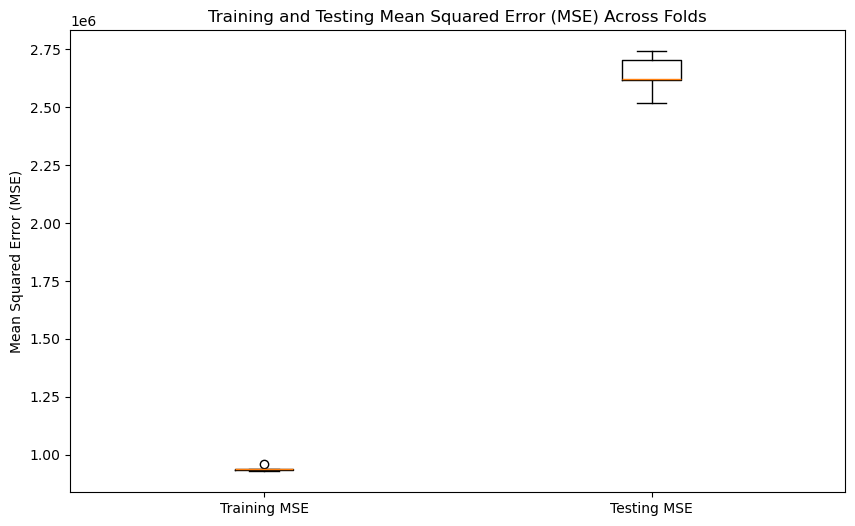

In [32]:
from sklearn.model_selection import cross_validate

# Define cross-validation strategy (e.g., 5-fold cross-validation)
cv_results = cross_validate(grid_search, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Extract train and test scores from cross-validation results
train_scores = -cv_results['train_score']  # Use negative scores for MSE
test_scores = -cv_results['test_score']

# Plot boxplot of training and testing MSE
plt.figure(figsize=(10, 6))
plt.boxplot([train_scores, test_scores], labels=['Training MSE', 'Testing MSE'])
plt.title('Training and Testing Mean Squared Error (MSE) Across Folds')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

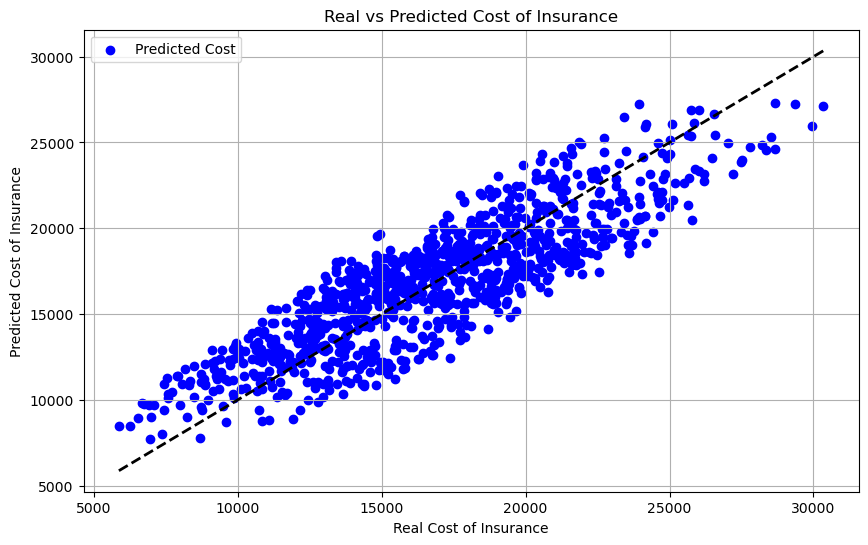

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_charges_test, y_charges_pred_rf, color='blue', label='Predicted Cost')
plt.plot([y_charges_test.min(), y_charges_test.max()], [y_charges_test.min(), y_charges_test.max()], 'k--', lw=2)
plt.xlabel('Real Cost of Insurance')
plt.ylabel('Predicted Cost of Insurance')
plt.title('Real vs Predicted Cost of Insurance')
plt.legend()
plt.grid(True)
plt.show()

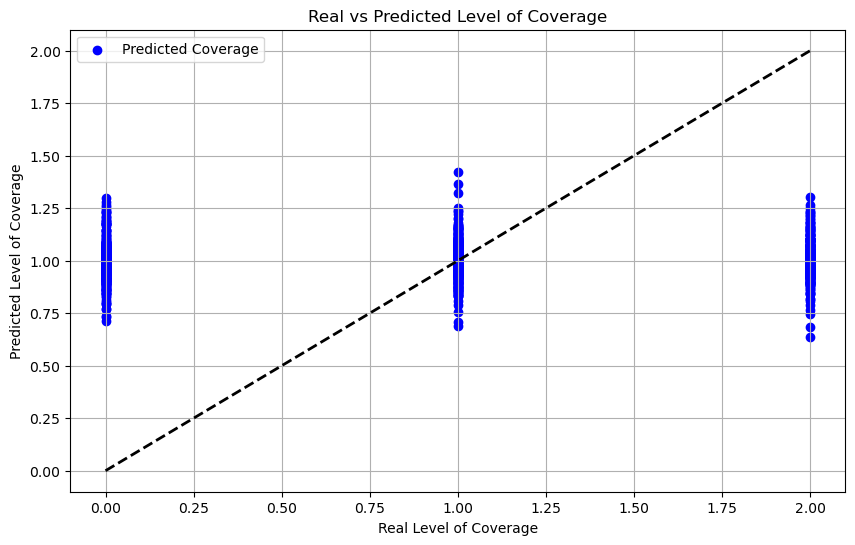

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_coverage_test, y_coverage_pred_rf, color='blue', label='Predicted Coverage')
plt.plot([y_coverage_test.min(), y_coverage_test.max()], [y_coverage_test.min(), y_coverage_test.max()], 'k--', lw=2)
plt.xlabel('Real Level of Coverage')
plt.ylabel('Predicted Level of Coverage')
plt.title('Real vs Predicted Level of Coverage')
plt.legend()
plt.grid(True)
plt.show()

#### SVM Evaluation

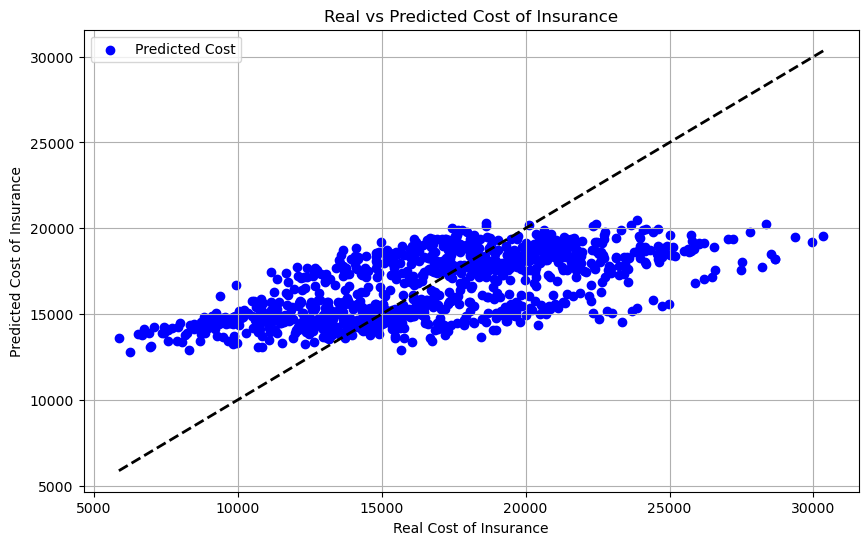

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(y_charges_test, y_charges_pred_svm, color='blue', label='Predicted Cost')
plt.plot([y_charges_test.min(), y_charges_test.max()], [y_charges_test.min(), y_charges_test.max()], 'k--', lw=2)
plt.xlabel('Real Cost of Insurance')
plt.ylabel('Predicted Cost of Insurance')
plt.title('Real vs Predicted Cost of Insurance')
plt.legend()
plt.grid(True)
plt.show()

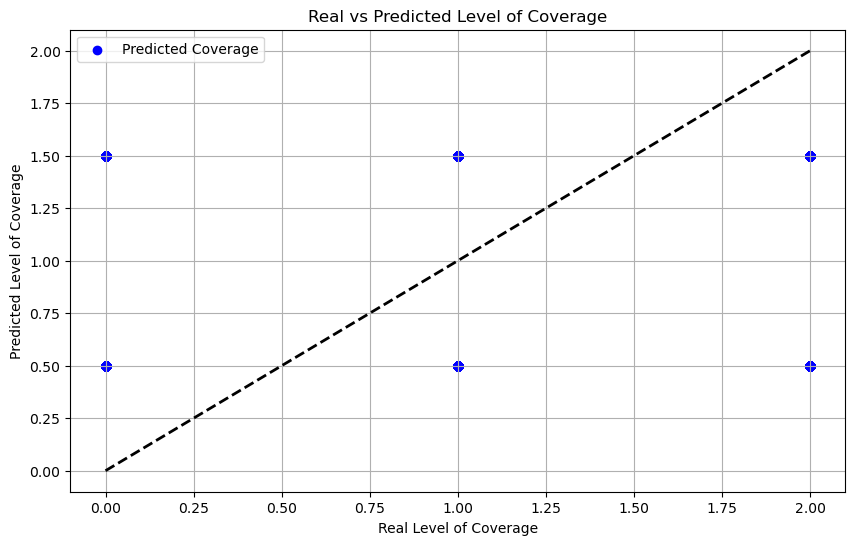

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(y_coverage_test, y_coverage_pred_svm, color='blue', label='Predicted Coverage')
plt.plot([y_coverage_test.min(), y_coverage_test.max()], [y_coverage_test.min(), y_coverage_test.max()], 'k--', lw=2)
plt.xlabel('Real Level of Coverage')
plt.ylabel('Predicted Level of Coverage')
plt.title('Real vs Predicted Level of Coverage')
plt.legend()
plt.grid(True)
plt.show()

#### Neural Network Evaluation

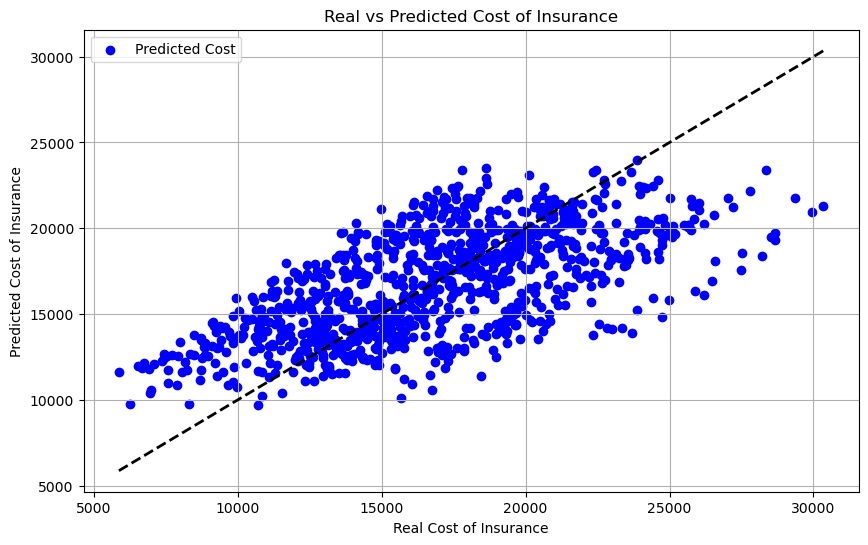

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(y_charges_test, y_charges_pred_nn, color='blue', label='Predicted Cost')
plt.plot([y_charges_test.min(), y_charges_test.max()], [y_charges_test.min(), y_charges_test.max()], 'k--', lw=2)
plt.xlabel('Real Cost of Insurance')
plt.ylabel('Predicted Cost of Insurance')
plt.title('Real vs Predicted Cost of Insurance')
plt.legend()
plt.grid(True)
plt.show()

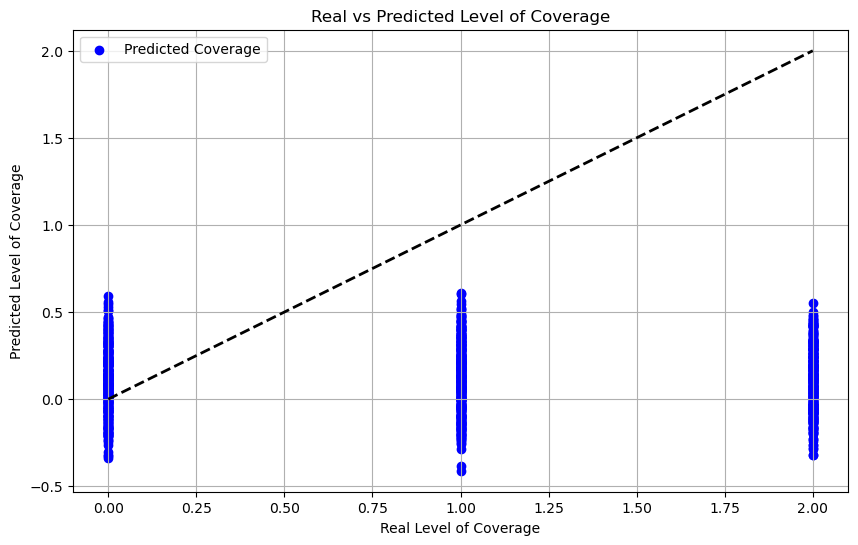

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_coverage_test, y_coverage_pred_nn, color='blue', label='Predicted Coverage')
plt.plot([y_coverage_test.min(), y_coverage_test.max()], [y_coverage_test.min(), y_coverage_test.max()], 'k--', lw=2)
plt.xlabel('Real Level of Coverage')
plt.ylabel('Predicted Level of Coverage')
plt.title('Real vs Predicted Level of Coverage')
plt.legend()
plt.grid(True)
plt.show()

### Part 2 - Optimisation

In [7]:
class Surgeon:
    def __init__(self, surgery_type, name, surgeries_per_day, anesthesiologist_required):
        self.surgery_type = surgery_type
        self.name = name
        self.surgeries_per_day = surgeries_per_day
        self.anesthesiologist_required = anesthesiologist_required

    def __str__(self):
        return f"Surgeon: {self.name}, Surgery Type: {self.surgery_type}, " \
               f"Surgeries per Day: {self.surgeries_per_day}, " \
               f"Anesthesiologist Required: {self.anesthesiologist_required}"
    
        

In [8]:
# Open the text file for reading
surgeons = [0 for _ in range(5)]
with open("Surgery.txt", "r") as file:
    i = 0
    
    for line in file:
        # Split the line into its components based on '|'
        components = line.strip().split('|')
        new_surgeon = Surgeon(components[0].strip(), components[1].strip(), int(components[2].strip()), components[3].strip() == "Yes")
        # Extract the components
        surgeons[i] = new_surgeon
        i+=1
        

print(surgeons[0].surgery_type)
print(surgeons[0].name)
print(surgeons[0].surgeries_per_day)
print(surgeons[0].anesthesiologist_required)

Cholecystectomy
Meredith Gery
4
True


In [9]:
timetable = [[0 for _ in range(9)] for _ in range(3)]

def timetable_dataframe():
    return pd.DataFrame(timetable)

timetable_df = timetable_dataframe()
timetable_df.tail()
    

,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0


In [10]:
import random

#30 Attempts to just place a random surgery in a random timeslot, 
# do not worry about conflicts as this will be improved upon by the hillclimb algorithm
def generate_random_timetable():
    for j in range(3):
        for k in range(9):
            timetable[j][k] = "Empty"
    
    for i in range (30):
        random.seed()
        x = random.randint(0, 2)#Get a random slot in the timetable
        y = random.randint(0, 8)
        random_surgeon = random.randint(0, 4)#Get a random surgeon
        timetable[x][y] = surgeons[random_surgeon]
        



generate_random_timetable()



timetable_df = timetable_dataframe()
timetable_df.tail()



,0,1,2,3,4,5,6,7,8
0,"Surgeon: Cristina Yang, Surgery Type: Carpal T...","Surgeon: Cristina Yang, Surgery Type: Carpal T...",Empty,"Surgeon: Beverly Crusher, Surgery Type: Dupuyt...","Surgeon: Preston Burke, Surgery Type: Heart By...","Surgeon: Leonard McCoy, Surgery Type: Broken B...",Empty,"Surgeon: Preston Burke, Surgery Type: Heart By...","Surgeon: Leonard McCoy, Surgery Type: Broken B..."
1,"Surgeon: Meredith Gery, Surgery Type: Cholecys...","Surgeon: Preston Burke, Surgery Type: Heart By...","Surgeon: Leonard McCoy, Surgery Type: Broken B...",Empty,"Surgeon: Cristina Yang, Surgery Type: Carpal T...","Surgeon: Leonard McCoy, Surgery Type: Broken B...","Surgeon: Beverly Crusher, Surgery Type: Dupuyt...","Surgeon: Meredith Gery, Surgery Type: Cholecys...",Empty
2,"Surgeon: Leonard McCoy, Surgery Type: Broken B...",Empty,"Surgeon: Preston Burke, Surgery Type: Heart By...","Surgeon: Beverly Crusher, Surgery Type: Dupuyt...","Surgeon: Preston Burke, Surgery Type: Heart By...","Surgeon: Cristina Yang, Surgery Type: Carpal T...","Surgeon: Beverly Crusher, Surgery Type: Dupuyt...",Empty,Empty


In [11]:



anaesthetists_count = 2 #Start with 2 available

# Step 2: Implement the fitness function
def calculate_fitness(timetable):
    # Initialize constraint violation counters
    concurrence_violations = 0
    precedence_violations = 0


    # Iterate through each time slot in the timetable
    for x in range(3):#Loop for each timeslot
        for y in range(9):#Loop for the 9 timeslots of the day
            if(timetable[x][y] == "Empty"):#Ignore cells that are empty
                continue
            #Check for concurrence violations
            for i in range (3):
                if (i != x):#Not for the current one
                    if(timetable[x][y] == timetable[i][y]):
                        concurrence_violations += 1
                        print("Conc", x, y ,"  ", i, y)
            #Check for precedence violations
            for i in range(3):
                if (timetable[x][y] == timetable[i][y-1]):
                    precedence_violations += 1
                    print("Pres", x, y ,"  ", i, y)

            
    
    # Calculate fitness score
    print(concurrence_violations)
    print(precedence_violations)
    fitness_score = concurrence_violations * precedence_violations
    return fitness_score







In [15]:
# Generate a random timetable

generate_random_timetable()



# Evaluate the fitness of the random timetable
fitness = calculate_fitness(timetable)
print("Fitness of Random Timetable:", fitness)

timetable_df = timetable_dataframe()
timetable_df.tail()

Pres 0 0    0 0
Pres 0 7    1 7
Pres 0 8    0 8
Pres 1 0    2 0
Pres 1 6    0 6
Pres 1 8    1 8
Pres 2 1    0 1
Pres 2 2    1 2
0
8
Fitness of Random Timetable: 0


,0,1,2,3,4,5,6,7,8
0,"Surgeon: Leonard McCoy, Surgery Type: Broken B...","Surgeon: Cristina Yang, Surgery Type: Carpal T...",Empty,"Surgeon: Preston Burke, Surgery Type: Heart By...","Surgeon: Beverly Crusher, Surgery Type: Dupuyt...","Surgeon: Leonard McCoy, Surgery Type: Broken B...","Surgeon: Preston Burke, Surgery Type: Heart By...","Surgeon: Leonard McCoy, Surgery Type: Broken B...","Surgeon: Leonard McCoy, Surgery Type: Broken B..."
1,"Surgeon: Preston Burke, Surgery Type: Heart By...","Surgeon: Meredith Gery, Surgery Type: Cholecys...","Surgeon: Beverly Crusher, Surgery Type: Dupuyt...",Empty,"Surgeon: Cristina Yang, Surgery Type: Carpal T...",Empty,"Surgeon: Leonard McCoy, Surgery Type: Broken B...","Surgeon: Meredith Gery, Surgery Type: Cholecys...","Surgeon: Meredith Gery, Surgery Type: Cholecys..."
2,Empty,"Surgeon: Leonard McCoy, Surgery Type: Broken B...","Surgeon: Meredith Gery, Surgery Type: Cholecys...",Empty,Empty,Empty,Empty,"Surgeon: Cristina Yang, Surgery Type: Carpal T...","Surgeon: Preston Burke, Surgery Type: Heart By..."
